# Supercritical pitchfork bifurcation of a column
This notebook shows the calculation of the supercritical pitchfork bifurcation of a pin-ended column loaded in compression with MSC Nastran SOL 106. We first recall the analytical results for a 1 DOF system and then we move on to the numerical computation.

## 1 DOF system
Let's take the 1 DOF system represented below, composed by two initially collinear rods with a linear torsional spring under axial compressive load $P$.

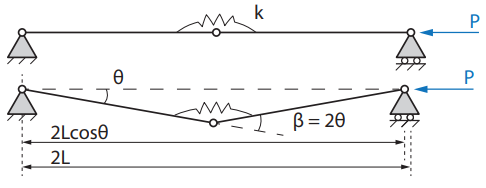

In [1]:
from IPython.display import Image
Image(filename='two_rods.PNG')

The equilibrium equation is satisfied under two conditions:
$$\theta=0$$
$$\frac{P}{P_{cr}}=\frac{\theta}{\sin\theta}$$
where $\theta=0$ is the trivial solution and $P_{cr}=2k/L$ is the buckling load.

For $\theta=0$ the equilibrium is stable for $P<P_{cr}$, while for $P/P_{cr}=\theta/\sin\theta$ the equilibrium is always stable.

If we add an imperfection to the system, like the initial angle $\theta_0$ shown below, the equilibrium changes.

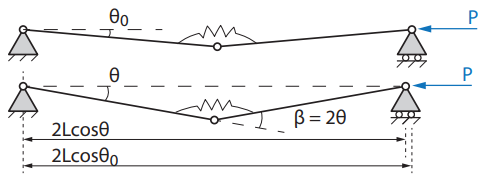

In [2]:
Image(filename='two_rods_imperfection.PNG')

The symmetry of the problem is broken and the equilibrium is found for the following condition:
$$\frac{P}{P_{cr}}=\frac{\theta-\theta_0}{\sin\theta}$$

If we plot the results we can observe the supercritical pitchfork bifurcation and the broken pitchfork.

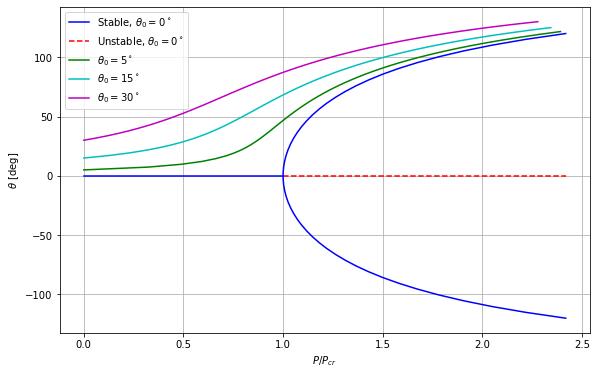

In [3]:
# Create figure
# %matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]
fig, ax = plt.subplots()

# Perfect system
import numpy as np
theta_trivial_stable = np.array([0., 0.])  # deg
load_trivial_stable = np.array([0., 1.])
theta_stable = np.linspace(-120, 120)  # deg
load_stable = np.deg2rad(theta_stable)/np.sin(np.deg2rad(theta_stable))
theta_trivial_unstable = np.array([0., 0.])  # deg
load_trivial_unstable = np.array([1., np.max(load_stable)])
style = {'stable': '-b', 'unstable': '--r'}
ax.plot(load_trivial_stable, theta_trivial_stable, style['stable'], label='Stable, $\\theta_0 = 0^\circ$')
ax.plot(load_trivial_unstable, theta_trivial_unstable, style['unstable'], label='Unstable, $\\theta_0 = 0^\circ$')
ax.plot(load_stable, theta_stable, style['stable'])

# Imperfection
imperfections = [5, 15, 30]  # deg
style = {5: '-g', 15: '-c', 30: '-m'}
for theta_0 in imperfections:
    theta_imperfection = np.linspace(theta_0, 120 + theta_0/3)
    load_imperfection = (np.deg2rad(theta_imperfection-theta_0))/np.sin(np.deg2rad(theta_imperfection))
    ax.plot(load_imperfection, theta_imperfection, style[theta_0], label='$\\theta_0={:d}^\circ$'.format(theta_0))

# Finish plot
ax.set_xlabel('$P/P_{cr}$')
ax.set_ylabel('$\\theta$ [deg]')
ax.legend()
ax.grid()
plt.show()

## Numerical model <a name="numerical-model"></a>
We consider a constant cross-sectional column with the following characteristics (inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539)):
 * Young's modulus $E=207$ GPa
 * Poisson's ratio $\nu=0.3$
 * density $\rho=7.8\cdot10^{-4}$ tons/mm$^3$
 * diameter $d=20$ mm
 * length $l=420$ mm

The shear modulus $G$ will be calculated by Nastran according to the following equation:
$$E=2(1+\nu)G.$$

We discretize the column into 420 beam elements and we consider a two-dimensional problem in the $xy$ plane, so permanent single-point constraints for all nodes are enforced for the corresponding degrees of freedom. For the boundary conditions we define two single-point constraints: a pin support at one end of the column and a roller support at the other end.

With the mentioned input variables we call the `create_column_base_model` function, which returns a `BDF` object with our base model. Finally, we define the name of our model.

In [4]:
import utils
E = 207000.  # [MPa]
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
d = 20  # [mm]
l = 420  # [mm]
no_elements = 420
model = utils.create_column_base_model(E, nu, rho, d, l, no_elements)
model_name = 'column_pitchfork_bifurcation'

subcase=0 already exists...skipping


Let's visualize some information about the model we have just created.

In [5]:
print(model.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcadds[3]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.params
  PARAM    : 2

bdf.nodes
  GRID     : 421

bdf.elements
  CBEAM    : 420

bdf.properties
  PBEAML   : 1

bdf.materials
  MAT1     : 1




Before moving on to the definition of the subcases, we calculate the buckling load using Euler's formula, so that we can nondimensionalize our results later.

In [6]:
I = np.pi*d**4/64  # [mm^4]
euler_buckling_load = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {euler_buckling_load:.2f} N')

Euler's buckling load: 90962.29 N


## Subcases definition
In order to reproduce the supercritical pitchfork bifurcation with our numerical model, we need to obtain the stable branch up to the buckling load, the unstable branch beyond the buckling load and one of the two symmetrical stable branches beyond the buckling load. In addition, we also want to visualize the broken pitchfork, in order to notice the influence of an initial imperfection. We define the following succession of subcases to achieve our objectives:
1. Apply a compression load larger than the buckling load. Initially this will move us along the straight stable branch of the pitchfork and as the load increases we will move on to the unstable branch.
2. Add a small transverse load at the middle of the column. This will break the symmetry of the problem and consequently the pitchfork, producing a certain deflection of the column.
3. Remove the transverse load in order to restore the symmetry of the problem. At this point also the pitchfork will be restored and the column will move onto the stable branch corresponding to the direction of the tranverse load that was applied in the previous subcase. As a consequence it will still be possible to observe a nonzero deflection of the column.
4. Remove the compression load. This will move us along the curved stable branch until we get back to the straight stable branch and we sweep it back to zero applied load.
5. Apply both the compression and the transverse load at the same time. This will let us visualize the path of the broken pitchfork.

Now let's start by defining the compression force and the transverse force, which we will later assign to the different load sets. We consider a compression force equal to 2 times the Euler buckling load, while we set the transverse force equal to 1 N.

In [7]:
# Compression force definition
compression_force_sid = list(model.spcadds.keys())[0]+1
last_node_id = no_elements+1
compression_force_magnitude = euler_buckling_load*2
compression_force_direction = [-1., 0., 0.]
model.add_force(sid=compression_force_sid, node=last_node_id, mag=compression_force_magnitude, xyz=compression_force_direction)
# Transverse force definition
transverse_force_sid = compression_force_sid+1
middle_node_id = int(no_elements/2+1)
transverse_force_magnitude = 1.
transverse_force_direction = [0., 1., 0.]
model.add_force(sid=transverse_force_sid, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

FORCE          5     211              1.      0.      1.      0.

Let's define the first subcase and the corresponding load set, which includes only the compression force.

In [8]:
subcase_id = 1
subtitle = 'Apply compression load'
load_sid = transverse_force_sid+1
force_sids = [compression_force_sid]
scale_factors = [1.]
utils.create_column_subcase(model, subcase_id, subtitle, load_sid, force_sids, scale_factors)

We proceed with the second subcase, where we add the transverse force.

In [9]:
subcase_id = 2
subtitle = 'Add transverse load'
load_sid = load_sid+1
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., 1.]
utils.create_column_subcase(model, subcase_id, subtitle, load_sid, force_sids, scale_factors)

We then define the third subcase, where we remove the transverse force.

In [10]:
subcase_id = 3
subtitle = 'Remove transverse load'
load_sid = load_sid+1
force_sids = [compression_force_sid]
scale_factors = [1.]
utils.create_column_subcase(model, subcase_id, subtitle, load_sid, force_sids, scale_factors)

Now we define the fourth subcase, where we remove also the compression load.

In [11]:
subcase_id = 4
subtitle = 'Remove compression load'
load_sid = load_sid+1
force_sids = [compression_force_sid]
scale_factors = [0.]
utils.create_column_subcase(model, subcase_id, subtitle, load_sid, force_sids, scale_factors)

Finally we define the fifth subcase, where we apply both the compression and the transverse load together. For the latter we use a larger magnitude to clearly distinguish the broken pitchfork from the standard one.

In [12]:
subcase_id = 5
subtitle = 'Apply compression and transverse load'
load_sid = load_sid+1
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., 1e3]
utils.create_column_subcase(model, subcase_id, subtitle, load_sid, force_sids, scale_factors)

## Full Newton method
We choose SOL 106 as solution sequence and we set the parameters for the nonlinear iteration strategy to use the full Newton method. For this purpose, we define a `NLPARM` card with the following parameters:
* `ninc=100` to set the number of load increments
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration
* `max_iter=50` to limit the number of iterations to 50 for each load increment
* `conv='UPV'` to select convergence criteria based on displacement error, load equilibrium error and vector component method
* `int_out='YES'` to process the output for every computed load increment
* `eps_u=0.001` and `eps_p=0.001` to set the error tolerance for the displacement and load criteria
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment

We assign the id of the `NLPARM` card as default for all subcases.

In [13]:
model.sol = 106
nlparm_id = 1
model.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=50, conv='UPV', int_out='YES', eps_u=0.001, eps_p=0.001, max_bisect=10)
model.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

We also need to define an additional parameter:
* `PARAM,LGDISP,1` to assume all nonlinear structural element types that have a large displacement capability to have large displacement effects

In [14]:
model.add_param('LGDISP', [1])

PARAM     LGDISP       1

Now let’s create an appropriate directory where we can run the analysis and let’s write our BDF object to an actual bdf file.

In [15]:
import os
pitchfork_directory = os.path.join(os.getcwd(), 'PitchforkBifurcationFullNewtonMethod')
os.makedirs(pitchfork_directory, exist_ok=True)
output_bdf_filename = os.path.join(pitchfork_directory, model_name + '.bdf')
model.write_bdf(output_bdf_filename)

We run the analysis.

In [16]:
from pyNastran.utils.nastran_utils import run_nastran
nastran_path = 'C:\\Program Files\\MSC.Software\\MSC_Nastran\\2021.4\\bin\\nastranw.exe'
run_nastran(output_bdf_filename, nastran_path, run_in_bdf_dir=True)
utils.wait_nastran(pitchfork_directory)

Once the analysis is done, we can read the op2 file and look for the load step, the applied load and the rotation (about $z$) at the pin-supported node for every subcase and every nonlinear iteration step.

In [17]:
# Read op2 file
from pyNastran.op2.op2 import read_op2
op2_filename = os.path.join(pitchfork_directory, model_name + '.op2')
op2 = read_op2(op2_filename, build_dataframe=True, debug=False)
# Store load step, applied load and rotation at the pin-supported node
load_step = {}
applied_load = {}
rotation = {}
for key in op2.load_vectors:
    load_step[key] = op2.load_vectors[key].lftsfqs
    applied_load[key] = np.apply_along_axis(np.linalg.norm, 1,
                                            np.apply_along_axis(np.sum, 1, op2.load_vectors[key].data[:, :, 0:3]))
    rotation[key] = np.rad2deg(op2.displacements[key].data[:, 1, 5])

We can now plot the load step versus the rotation at the pin-supported node and the applied load versus the same rotation for every converged iteration of each subcase.

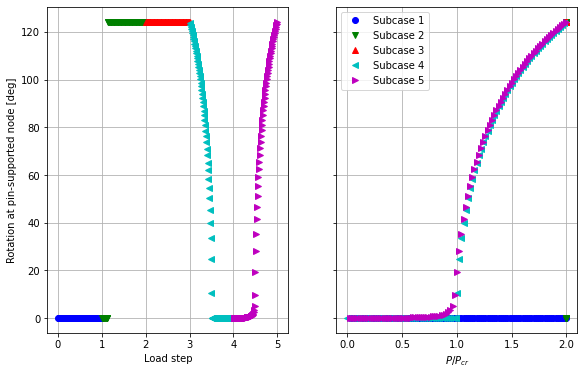

In [18]:
# Set plotting style for different subcases
style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m'}
# Create figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=2, sharey='all')
# Plot load step vs vertical displacement
for key in rotation:
    axs[0].plot(load_step[key], rotation[key], style[key], label='Subcase {:d}'.format(key))
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('Rotation at pin-supported node [deg]')
    axs[0].grid(visible=True)
# Plot applied load vs vertical displacement
for key in rotation:
    axs[1].plot(applied_load[key]/euler_buckling_load, rotation[key], style[key], label='Subcase {:d}'.format(key))
    axs[1].set_xlabel('$P/P_{cr}$')
    axs[1].legend()
    axs[1].grid(visible=True)
plt.show()

## Arc-length method
Now we try to obtain the same results using the arc-length incremental solution strategy. For this purpose we define a `NLPCI` card with the following parameters:
* `Type='CRIS'` to set Crisfield constraint type
* `minalr=.01` to set the minimum allowable arc-length adjustment ratio between increments, $\frac{\Delta l_{new}}{\Delta l_{old}}\geq MINALR$
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase

In [19]:
model.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, desiter=5, mxinc=2000)

NLPCI          1    CRIS     .01      4.      0.               5    2000

We create the analysis directory, write the bdf file and run the analysis with Nastran.

In [20]:
pitchfork_directory = os.path.join(os.getcwd(), 'PitchforkBifurcationArcLength')
os.makedirs(pitchfork_directory, exist_ok=True)
output_bdf_filename = os.path.join(pitchfork_directory, model_name + '.bdf')
model.write_bdf(output_bdf_filename)
run_nastran(output_bdf_filename, nastran_path, run_in_bdf_dir=True)
utils.wait_nastran(pitchfork_directory)

Similarly to what was done previously, we read the op2 file, we store load step, applied load and rotation at the pin-supported node and finally we plot the load step versus the rotation at the pin-supported node and the applied load versus the same rotation.

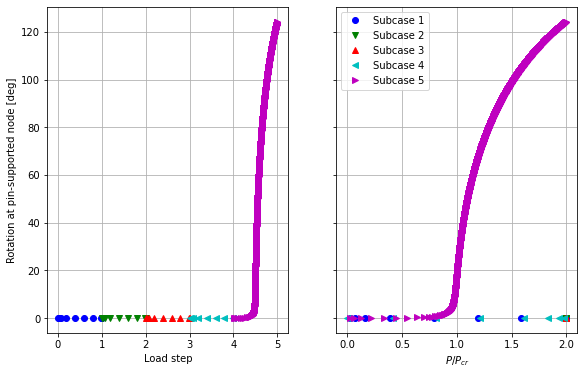

In [21]:
# Read op2 file
op2_filename = os.path.join(pitchfork_directory, model_name + '.op2')
op2 = read_op2(op2_filename, build_dataframe=True, debug=False)
# Store load step, applied load and rotation at the pin-supported node
load_step = {}
applied_load = {}
rotation = {}
for key in op2.load_vectors:
    load_step[key] = op2.load_vectors[key].lftsfqs
    applied_load[key] = np.apply_along_axis(np.linalg.norm, 1,
                                            np.apply_along_axis(np.sum, 1, op2.load_vectors[key].data[:, :, 0:3]))
    rotation[key] = np.rad2deg(op2.displacements[key].data[:, 1, 5])
# Create figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=2, sharey='all')
# Plot load step vs vertical displacement
for key in rotation:
    axs[0].plot(load_step[key], rotation[key], style[key], label='Subcase {:d}'.format(key))
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('Rotation at pin-supported node [deg]')
    axs[0].grid(visible=True)
# Plot applied load vs vertical displacement
for key in rotation:
    axs[1].plot(applied_load[key]/euler_buckling_load, rotation[key], style[key], label='Subcase {:d}'.format(key))
    axs[1].set_xlabel('$P/P_{cr}$')
    axs[1].legend()
    axs[1].grid(visible=True)
plt.show()

The results with the arc-length method appear to be correct only for the broken pitchfork, while the "pristine" pitchfork is not captured with the employed succession of subcases. According to MSC Nastran support the arc-length method is not reliable in SOL 106 and convergence beyond the critical point is always a problem. Since the arc-length method is based on a predictor-corrector strategy, what may be happening is that the solver struggles to find a converged solution in the initial direction and as a consequence bounces back to the equilibrium branch where it started.